# Réseaux de neurones unrolled pour le défloutage

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
# from tensorboardX import SummaryWriter

from DIDN import DIDN
import scripts.metrics as metrics
from scripts.recon import cg

In [2]:
batch_size = 4
batch_size_test = 64
nchans = 3
nx = ny = 96
device = torch.device('cuda:0')

noiselevel = 3e-2
kernelsize = 11
sigma = 1.

Définition du chemin où le jeu de données est enregistré.

In [4]:
root = '/media/DATA/STL10_dataset'


def normalize(tensor):
    mini = tensor.amin(axis=(0,1,2), keepdim=True)
    maxi = tensor.amax(axis=(0,1,2), keepdim=True)
    return (tensor-mini)/(maxi-mini)


transform = transforms.Compose([
    transforms.Resize((nx, ny)),
    transforms.ToTensor(),
    transforms.Lambda(normalize),
])
dataset_train = datasets.STL10(root=root, split="train", transform=transform, download=False)
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
dataset_test = datasets.STL10(root=root, split="test", transform=transform, download=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size_test, shuffle=True)
print('nb images in training dataset:',len(dataset_train))
print('nb images in testing dataset:',len(dataset_test))

nb images in training dataset: 5000
nb images in testing dataset: 8000


Définir du noyau de convolution non périodique gaussien et appliquer ce noyau à une image. Afficher l'image de départ et celle floutée. Puis ajouter du bruit sur l'image floutée et l'afficher.

torch.Size([3, 1, 11, 11])


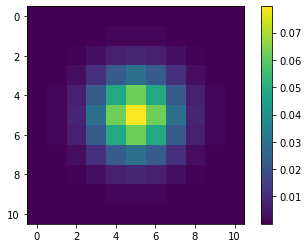

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


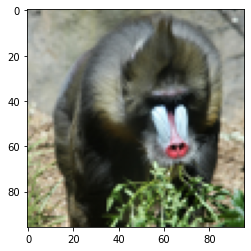

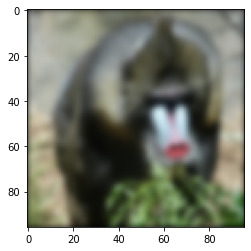

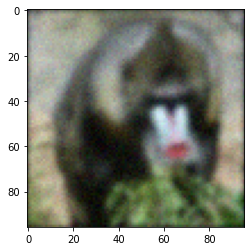

In [5]:

x_coord = torch.arange(kernelsize)
x_grid = x_coord.repeat(kernelsize).view(kernelsize, kernelsize)
y_grid = x_grid.t()
mean = (kernelsize - 1)/2.


quadform = ((x_grid-mean)**2+(y_grid-mean)**2)/(2*sigma**2)
gaussian_kernel = torch.exp(-0.5*quadform.view(kernelsize, kernelsize))
gaussian_kernel = gaussian_kernel/torch.sum(gaussian_kernel)
gaussian_kernel = gaussian_kernel.view(1, 1, kernelsize, kernelsize)
gaussian_kernel = gaussian_kernel.repeat(nchans, 1, 1, 1).to(device)
print(gaussian_kernel.shape)

plt.figure(0)
c=plt.imshow(gaussian_kernel[0,0].cpu())
plt.colorbar(c)
plt.show()

f = next(iter(train_loader))[0].to(device)

f_conv = nn.functional.conv2d(f, gaussian_kernel, groups=nchans, padding=(kernelsize-1)//2)
f_noise = f_conv+torch.randn_like(f_conv)*noiselevel

plt.figure(1)
plt.imshow(f[0].cpu().permute(1,2,0))
plt.figure(2)
plt.imshow(f_conv[0].cpu().permute(1,2,0))
plt.figure(3)
plt.imshow(f_noise[0].cpu().permute(1,2,0))
plt.show()

Ecrire une fonction réalisant l'optimisation du modèle sur une epoch.

In [6]:
def train(epoch, model, optim, train_loader, verbose=2, writer=None):
    model.train()
    Niter = len(train_loader)
    if verbose>=2:
        iterfn = lambda x: x
    else:
        print("Training epoch {:<3}".format(epoch))
        iterfn = tqdm
    for nit, data in enumerate(iterfn(train_loader)):
        f = data[0].to(device)
        optim.zero_grad()
        blurred = model.blur(f) + torch.randn_like(f)*noiselevel
        f_tilde = model(blurred)
        loss = metrics.l2err(f, f_tilde).mean()
        loss.backward()
        optim.step()
        psnr = metrics.psnr(f, f_tilde)
        mean_psnr = psnr.mean()
        if verbose>=2:
            print("  Epoch {:<3} It {:<4}/{:<4} cost={:1.3e}  PSNR={:.3f}".format(epoch, nit, Niter, loss, mean_psnr))
        if writer is not None:
            writer.add_scalar('loss/train', loss.item(), epoch*Niter+nit)
            writer.add_scalar('psnr/train', mean_psnr.item(), epoch*Niter+nit)

Coder une fonction testant le modèle sur tout le jeu de données test et qui renvoie un array numpy des PSNR associés à chaque image.

In [7]:
def test(model, test_loader):
    model.eval()
    test_psnr = []
    with torch.no_grad():
        for data in tqdm(test_loader):
            f = data[0].to(device)
            blurred = model.blur(f)
            f_tilde = model(blurred)
            loss = metrics.l2err(f, f_tilde).mean()
            psnr = metrics.psnr(f, f_tilde)
            for p in psnr:
                test_psnr.append(p.item())
    return np.array(test_psnr)

Implémenter une fonction appelant $Nepoch$ fois la fonction train et test. Ne pas oublier d'appeler un éventuel scheduler passé en argument.

In [8]:
def run(model, optim, train_loader, test_loader, scheduler=None, Nepoch=10, verbose=1, writer=None):
    for epoch in range(Nepoch):
        train(epoch, model, optim, train_loader, verbose=verbose, writer=writer)
        psnr = test(model, test_loader)
        mean_psnr = psnr.mean()
        if writer is not None:
            writer.add_scalar('psnr/test', mean_psnr.item(), epoch)
        if verbose:
            print("  Epoch {:<3}  PSNR={:.3f}".format(epoch, mean_psnr))
        if scheduler is not None:
            scheduler.step()

## Reconstructeur adjoint

In [9]:
class DeblurAdj(nn.Module):
    def __init__(self, gaussian_kernel, num_chans_net=32, bias=True):
        super(DeblurAdj, self).__init__()
        self.gaussian_kernel = nn.Parameter(gaussian_kernel, requires_grad=False)
        self.nchans = gaussian_kernel.shape[0]
        self.kernelsize = gaussian_kernel.shape[2]
        self.net = DIDN(self.nchans, self.nchans, num_chans=num_chans_net, bias=bias)
    def blur(self, f):
        return nn.functional.conv2d(f, self.gaussian_kernel, groups=self.nchans, padding=(self.kernelsize-1)//2)
    def blur_transpose(self, y):
        return nn.functional.conv_transpose2d(y, self.gaussian_kernel, groups=self.nchans, padding=(self.kernelsize-1)//2)
    def forward(self, y):
        f_tilde = self.net(self.blur_transpose(y))
        return f_tilde

In [13]:
model_adj = DeblurAdj(gaussian_kernel, num_chans_net=32).to(device)

In [14]:
optim = torch.optim.Adam(model_adj.parameters(), lr=1e-3, betas=(0.9, 0.999))

In [15]:
writer = SummaryWriter('tblogs/deblurring/adj')
run(model_adj, optim, train_loader, test_loader, Nepoch=1, verbose=1, writer=writer)

Training epoch 0  


100%|██████████| 125/125 [00:07<00:00, 16.38it/s]

  Epoch 0    PSNR=21.538


## Unrolled forward-backward

In [16]:
class DeblurUnrolledFB(nn.Module):
    def __init__(self, gaussian_kernel, Nunrolled, num_chans_net=32, bias=True):
        super(DeblurUnrolledFB, self).__init__()
        self.Nunrolled = Nunrolled
        self.gaussian_kernel = nn.Parameter(gaussian_kernel, requires_grad=False)
        self.nchans = gaussian_kernel.shape[0]
        self.kernelsize = gaussian_kernel.shape[2]
        self.net = nn.ModuleList([DIDN(self.nchans, self.nchans, num_chans=num_chans_net, bias=bias) for k in range(self.Nunrolled)])
    def precompute(self, f):
        x=torch.ones_like(f[:1])
        normx = x.pow(2).sum().sqrt()
        for i in range(100):
            x = x/normx
            x = self.blur_transpose(self.blur(x))
            normx = x.pow(2).sum().sqrt()
        self.gamma = 1/normx
    def blur(self, f):
        return nn.functional.conv2d(f, self.gaussian_kernel, groups=self.nchans, padding=(self.kernelsize-1)//2)
    def blur_transpose(self, y):
        return nn.functional.conv_transpose2d(y, self.gaussian_kernel, groups=self.nchans, padding=(self.kernelsize-1)//2)
    def forward(self, y):
        z = self.blur_transpose(y)
        for k in range(self.Nunrolled):
            grad = self.blur_transpose(self.blur(z)-y)
            xhat = z-self.gamma*grad
            z = self.net[k](xhat)
        return z

In [20]:
Nunrolled = 6
model_fb = DeblurUnrolledFB(gaussian_kernel, Nunrolled, num_chans_net=32).to(device)
model_fb.precompute(next(iter(train_loader))[0].to(device))

In [21]:
optim = torch.optim.Adam(model_fb.parameters(), lr=1e-3, betas=(0.9, 0.999))

In [22]:
writer = SummaryWriter('tblogs/deblurring/unrolled_fb')
run(model_fb, optim, train_loader, test_loader, Nepoch=1, verbose=1, writer=writer)

Training epoch 0  


100%|██████████| 125/125 [00:31<00:00,  4.02it/s]

  Epoch 0    PSNR=22.066


## Unrolled ADMM

In [23]:
class DeblurUnrolledADMM(nn.Module):
    def __init__(self, gaussian_kernel, Nunrolled, nitermaxcg, num_chans_net=32, bias=True, beta=1.):
        super(DeblurUnrolledADMM, self).__init__()
        self.Nunrolled = Nunrolled
        self.gaussian_kernel = nn.Parameter(gaussian_kernel, requires_grad=False)
        self.nchans = gaussian_kernel.shape[0]
        self.kernelsize = gaussian_kernel.shape[2]
        self.net = nn.ModuleList([DIDN(self.nchans, self.nchans, num_chans=num_chans_net, bias=bias) for k in range(self.Nunrolled)])
        self.beta = beta
        self.nitermaxcg = nitermaxcg
    def precompute(self, f):
        x=torch.ones_like(f[:1])
        normx = x.pow(2).sum().sqrt()
        for i in range(100):
            x = x/normx
            x = self.blur_transpose(self.blur(x))
            normx = x.pow(2).sum().sqrt()
        self.gamma = 1/normx
    def blur(self, f):
        return nn.functional.conv2d(f, self.gaussian_kernel, groups=self.nchans, padding=(self.kernelsize-1)//2)
    def blur_transpose(self, y):
        return nn.functional.conv_transpose2d(y, self.gaussian_kernel, groups=self.nchans, padding=(self.kernelsize-1)//2)
    def _Cop(self, x):
        return self.blur_transpose(self.blur(x)) + self.beta*x
    def forward(self, y):
        x = self.blur_transpose(y)
        z = x.clone()
        mu = torch.zeros_like(x)
        for k in range(self.Nunrolled):
            # x step
            rhs = self.blur_transpose(y)+self.beta*z-mu
            x, _ = cg(self._Cop, rhs, self.nitermaxcg)

            # z step
            z = self.net[k](x+mu/self.beta)

            # mu step
            mu = mu+self.beta*(x-z)
        return z

In [24]:
Nunrolled = 5
nitermaxcg = 10
model_admm = DeblurUnrolledADMM(gaussian_kernel, Nunrolled, nitermaxcg, num_chans_net=32).to(device)
model_admm.precompute(next(iter(train_loader))[0].to(device))

In [25]:
optim = torch.optim.Adam(model_admm.parameters(), lr=1e-3, betas=(0.9, 0.999))

In [27]:
writer = SummaryWriter('tblogs/deblurring/unrolled_admm')
run(model_admm, optim, train_loader, test_loader, Nepoch=1, verbose=1, writer=writer)

Training epoch 0  


100%|██████████| 125/125 [01:11<00:00,  1.76it/s]

  Epoch 0    PSNR=21.883
